## Benchmark 6 revisit: linear models with structured bootstrap resampling
OK, so first round of linear model submissions to the public leaderboard produced some concerning results. TLDR: control resampling distribution seems to predict public leaderboard result well, linear models do not. Bootstrapping result look as if both Seigel and Theil-Sen regression will beat naive control with high probability, but both receive low scores that are extremely unlikely given their observed bootstrapped score distributions. What's going on? Let's try and find out - first thing is to check every step by manually inspecting output for sanity.

Note: this is version 2 of this notebook, version 1 was preserved in the state which produced the suspect results under investigation for reference.

While we are at it, let's start a major refactor here and move away from using notebooks for our main data generating logic and functions and instead use them just for plotting and discussion.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Results](#results)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

In [23]:
import sys
sys.path.append('..')
import config as conf

paths = conf.DataFilePaths()
params = conf.LinearModelsBootstrappingParameters()

import statistics
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import NormalDist

<a name="results"></a>
### 2. Results

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.006390,0.025974,1.417735,1.372584,"[1.6615496, 1.4357955, 1.4628861, 1.4177352]","[-0.014477799999999874, -0.22575410000000007, ...",1.408705
1,0,OLS,4,0.066225,0.010947,1.318403,1.393369,"[1.6615496, 1.4357955, 1.4628861, 1.4177352]","[-0.014477799999999874, -0.22575410000000007, ...",1.408705
2,0,TS,4,0.086957,0.005399,1.291313,1.401121,"[1.6615496, 1.4357955, 1.4628861, 1.4177352]","[-0.014477799999999874, -0.22575410000000007, ...",1.408705
3,0,Seigel,4,0.025974,0.005399,1.372584,1.401121,"[1.6615496, 1.4357955, 1.4628861, 1.4177352]","[-0.014477799999999874, -0.22575410000000007, ...",1.408705
4,0,Ridge,4,0.044226,0.015767,1.347751,1.386667,"[1.6615496, 1.4357955, 1.4628861, 1.4177352]","[-0.014477799999999874, -0.22575410000000007, ...",1.408705


In [3]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,OLS,4,2.541123,3.777681
1,0,OLS,8,2.753783,2.654862
2,0,OLS,16,7.691742,7.094598
3,0,Ridge,4,2.420211,3.413861
4,0,Ridge,8,2.663964,2.628700


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

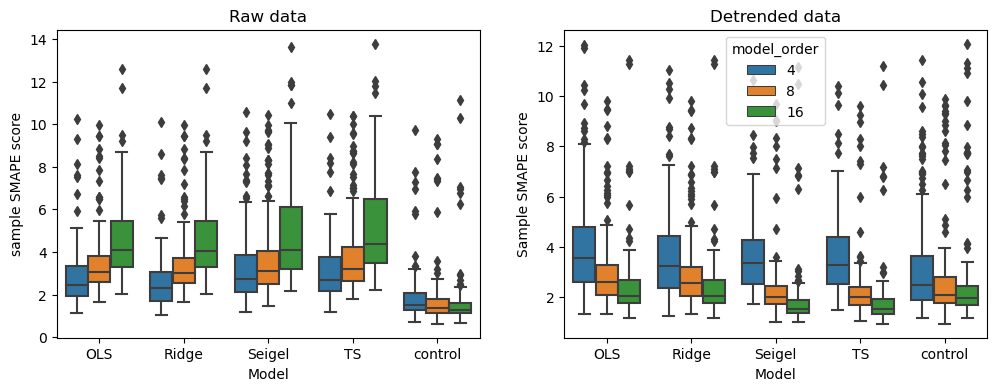

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)
        # Collect detrended model forecast
ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample SMAPE score', 
    title='Detrended data'
)

plt.show()

Now, let's compare another way by plotting individual SMAPE values for all the datapoints in control vs regression.


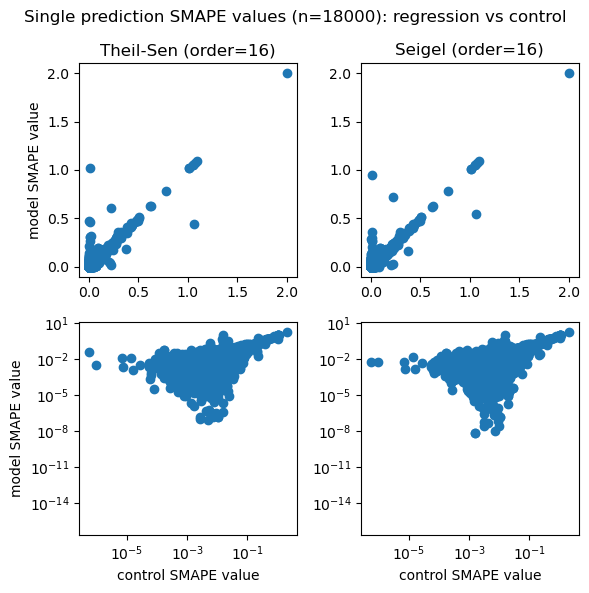

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[0,0].set_ylabel('model SMAPE value')
ax[0,0].set_title('Theil-Sen (order=16)')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[0,1].set_title('Seigel (order=16)')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('control SMAPE value')
ax[1,0].set_ylabel('model SMAPE value')

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('control SMAPE value')

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

Let's take a closer look at our winner(s).

In [7]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,OLS,4,2.839967,4.045754
1,OLS,8,3.440590,3.029747
2,OLS,16,4.501699,2.454577
3,Ridge,4,2.544199,3.685824
4,Ridge,8,3.380547,2.997795


In [10]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
1000,0,control,16,0.013015,0.028333,1.965769,1.886141,"[2.0694494, 2.3149772, 2.3149772, 2.2697852, 2...","[0.03507539999999976, 0.24552780000000007, 0.0...",1.940349
1005,0,control,16,0.171429,0.230720,2.050729,2.177323,"[2.1801491, 2.1227767, 2.0654044, 1.9791094, 2...","[0.0, -0.05737239999999977, -0.057372300000000...",1.726929
1010,0,control,16,0.038581,0.039316,2.804026,2.806089,"[2.6013248, 2.8861663, 2.8432684, 2.8122275, 2...","[-0.4032395000000002, 0.2848415000000002, -0.0...",2.697891


In [13]:
winner.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
1003,0,Seigel,16,0.036996,0.000864,2.013487,1.938673,"[2.0694494, 2.3149772, 2.3149772, 2.2697852, 2...","[0.03507539999999976, 0.24552780000000007, 0.0...",1.940349
1008,0,Seigel,16,0.186519,0.171429,2.082163,2.050729,"[2.1801491, 2.1227767, 2.0654044, 1.9791094, 2...","[0.0, -0.05737239999999977, -0.057372300000000...",1.726929
1013,0,Seigel,16,0.038207,0.041926,2.802977,2.813423,"[2.6013248, 2.8861663, 2.8432684, 2.8122275, 2...","[-0.4032395000000002, 0.2848415000000002, -0.0...",2.697891


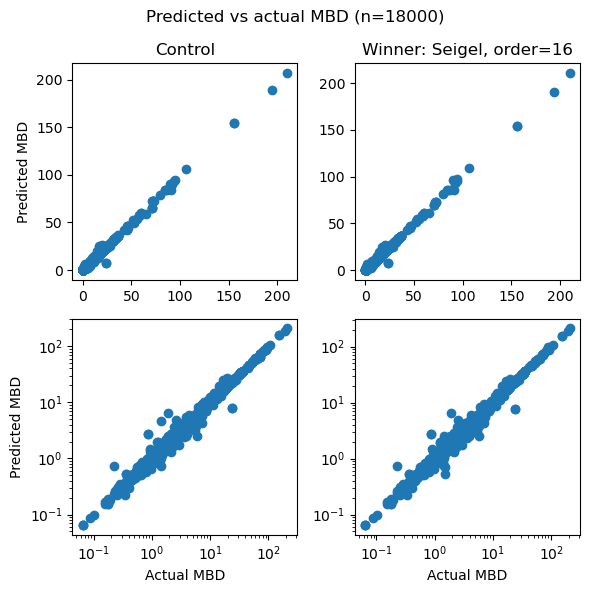

In [14]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')

ax[0,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')

ax[1,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
plt.tight_layout()

In [15]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['SMAPE_score'].describe()

count    180.000000
mean       1.598984
std        1.321298
min        0.688695
25%        1.114703
50%        1.292719
75%        1.621147
max       11.116719
Name: SMAPE_score, dtype: float64

In [16]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_SMAPE_score'].describe()

count    180.000000
mean       1.824131
std        1.284191
min        0.989705
25%        1.349153
50%        1.509173
75%        1.865502
max       11.149918
Name: detrended_SMAPE_score, dtype: float64

In [20]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_SMAPE_score'], control_sample_smape_scores['SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.3f}')

t-test p-value (H0: control mean = regression mean): 0.102


In [25]:

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.4f}, {ci[1]:.3f}')

95% C.I. around difference in means: -0.0449, 0.495


In [26]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Mean: {smape_mean:.3f}')
print(f'Standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Mean: 1.824
Standard deviation: 1.2806

Probability of SMAPE <= 1.0936: 0.284
Probability of SMAPE > 1.0936: 0.716
